<a href="https://colab.research.google.com/github/scmassey/model-sensitivity-analysis/blob/master/LHS_PRCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latin Hypercube Sampling & Partial Rank Correlation Coefficients  <br/> *~ a method for analyzing model sensitivity to parameters ~*

#### Importing packages that will be used.

In [0]:
import numpy as np

from scipy import special

import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import pandas as pd

import matplotlib.pyplot as plt


### Specify the number of parameters to sample and the number of samples to draw from each parameter distribution. 
#### *Do not include any parameters that should be left fixed in parameterCount - those will be specified later. When choosing number of samples to draw, note that more samples (~ 1000) yields better results while fewer (~50) is faster for testing, since it requires fewer model solves.* 

In [0]:
# Number of parameters to sample 
parameterCount = 2;

# Number of samples to draw for each parameter
sampleCount = 100; 

#### This defines the function for drawing samples from a user-specified parameter distribution. Does not need any user edits.

In [0]:
def sampleDistrib(modelParamName,distrib,distribSpecs): 
    
    if distrib == 'uniform':
        
        mmin = distribSpecs[0]
        mmax = distribSpecs[1]
        
        intervalwidth = (mmax - mmin) / sampleCount      # width of each 
                                                         # sampling interval
        samples = []
        
        for sample in range(sampleCount):
            
            lower = mmin + intervalwidth * (sample-1)    # lb of interval
            upper = mmin + intervalwidth * (sample)      # ub of interval
            
            sampleVal = np.random.uniform(lower, upper)  # draw a random sample 
                                                         # within the interval
            samples.append(sampleVal)

    
    
    elif distrib == 'normal':
        
        mmean= distribSpecs[0]
        mvar = distribSpecs[1]
        
        lower = mvar*np.sqrt(2)*special.erfinv(-0.9999)+mmean # set lb of 1st
                                                              # sample interval
        samples = []
        
        for sample in range(sampleCount):
            
            upper = (mvar*np.sqrt(2)
                     *special.erfinv(2/sampleCount + special.erf(lower - mmean) 
                                     / (mvar * np.sqrt(2))) 
                     + mmean)                            # ub of sample interval
 
            sampleVal = np.random.uniform(lower, upper)  # draw a random sample 
                                                         # within the interval
            samples.append(sampleVal)

            lower = upper           # set current ub as the lb for next interval
            

    
    elif distrib == 'triangle':
        
        mmin = distribSpecs[0]
        mmax = distribSpecs[1]
        mmode= distribSpecs[2]
    
        samples = []
        
        for sample in range(sampleCount):
            
            intervalarea = 1/sampleCount 
            
            ylower = intervalarea*(sample-1) # use cdf to read off area as y's &
            yupper = intervalarea*(sample)   # get corresponding x's for the pdf
        
        
            # Check to see if y values = cdf(x <= mmode) 
            # for calculating correxponding x values:
            
            if ylower <= ((mmode - mmin)/(mmax - mmin)):     
                lower = np.sqrt(ylower*(mmax - mmin)*(mmode - mmin)) + mmin 

            else:
                lower = mmax-np.sqrt((1 - ylower)*(mmax - mmin)*(mmax - mmode))

            
            if yupper <= ((mmode - mmin)/(mmax - mmin)):    
                upper = np.sqrt(yupper*(mmax - mmin)*(mmode - mmin)) + mmin; 

            else:
                upper = mmax-np.sqrt((1 - yupper)*(mmax - mmin)*(mmax - mmode))

                
            sampleVal = np.random.uniform(lower, upper)   
            
            samples.append(sampleVal)
            
    
    
    plt.hist(samples,density=1, bins=5) 
    plt.show()
    
    
    return samples 

#### Call to the above function using interactive - user can use the boxes and dropdowns to specify parameter distributions and draw samples. 
## TRY USING ASYNCIO TO PAUSE FOR USER INPUT BEFORE GENERATING THE SAMPLES

Text(value='Type parameter 0 name here', description='Name:')

Dropdown(description='Distribution:', options=('uniform', 'normal', 'triangle'), value='uniform')

FloatText(value=0.0, description='Minimum:')

FloatText(value=5.0, description='Maximum:')

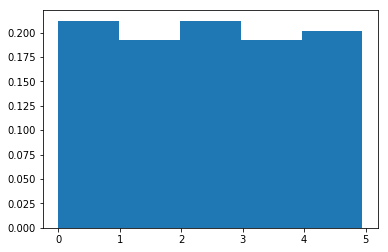

Text(value='Type parameter 1 name here', description='Name:')

Dropdown(description='Distribution:', options=('uniform', 'normal', 'triangle'), value='uniform')

FloatText(value=0.0, description='Minimum:')

FloatText(value=5.0, description='Maximum:')

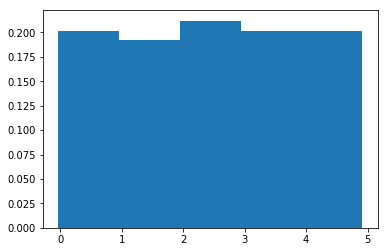

In [139]:
parameters = {}

for param in range(parameterCount):
  
    myDict={}
    
    s=str(param)
    
    modelParamName = widgets.Text(value='Type parameter ' + s 
                                  + ' name here',description='Name:')
    
    distrib = widgets.Dropdown(options = ['uniform','normal','triangle'],
                               description='Distribution:',)

    display(modelParamName, distrib)
    
    distribSpecs = [0,5]

    if distrib.value == 'uniform':

            mymin = widgets.FloatText(
                    value=0,
                    description='Minimum:',
                    disabled=False
                  )
            mymax = widgets.FloatText(
                    value=5,
                    description='Maximum:',
                    disabled=False
                  )

            display(mymin, mymax)

            mmin = mymin.value
            mmax = mymax.value

            distribSpecs = [mmin,mmax]
            
            myDict[modelParamName.value] = sampleDistrib(modelParamName.value,
                                                         distrib.value,distribSpecs)

    elif distrib.value == 'normal':

            mymean = widgets.FloatText(
                    value=1,
                    description='Mean:',
                    disabled=False
                  ) 
            myvar  = widgets.FloatText(
                    value=1,
                    description='Variance:',
                    disabled=False
                  ) 

            display(mymean, myvar)

            mmean = mymean.value
            mvar = myvar.value

            distribSpecs = [mmean,mvar]
            
            myDict[modelParamName.value] = sampleDistrib(modelParamName.value,
                                                         distrib.value,distribSpecs)

    elif distrib.value == 'triangle':

            mymin  = widgets.FloatText(
                    value=0,
                    description='Minimum:',
                    disabled=False
                  )
            mymax  = widgets.FloatText(
                    value=2,
                    description='Maximum:',
                    disabled=False
                  )
            mymode = widgets.FloatText(
                    value=1,
                    description='Mode:',
                    disabled=False
                  )

            display(mymin, mymax, mymode)

            mmin = mymin.value
            mmax = mymax.value
            mmode=mymode.value

            distribSpecs = [mmin,mmax,mmode]
            
            myDict[modelParamName.value] = sampleDistrib(modelParamName.value,
                                                         distrib.value,distribSpecs)

    parameters.update(myDict);
    

#### Randomly permute each set of parameter samples in order to randomly pair the samples to more fully sample the parameter space for the Monte Carlo simulations.

In [0]:
LHSparams=[]

for p in parameters:
    
    temp = parameters[p]
    random.shuffle(temp)
    
    LHSparams.append(temp)

## Define your model function here -
### A trivial example has been provided,  but in practice may be ode or pde.

In [0]:
def testlinear(x,sampledParams,unsampledParams):

    m = sampledParams[0]
    b = sampledParams[1]
    
    a = unsampledParams

    y = m * x + b + a;

    return y    

In [0]:
# def myodes(y, t, sampledParams, unsampledParams):

#     r, s, a = y                           # unpack current values of y

#     rho, mus, mur, gamma = sampledParams  # unpack sampled parameters

#     lambdaa, muu = unsampledParams        # unpack unsampled parameters

#     derivs = [rho*s- mus*gamma*a*s,       # list of dy/dt=f functions
#               rho*r - mur*gamma*a*r,
#               muu*t - lambdaa*a]

#     return derivs


### Run Monte Carlo simulations for each parameter sample set.
## *Be sure to specify your model function and necessary arguments.* 
Note that I have not used dict keys here for the parameters, so order needs to be maintained for accuracy. May update to use dict keys to ensure parameters are used appropriately in the model solving step.

In [0]:
# EDIT THE FOLLOWING VARIABLES, UNSAMPLED PARAMETERS, & ANY OTHER ARGS HERE,
# AS WELL AS THE CALL TO YOUR OWN MODEL FUNCTION INSIDE THE FOR LOOP BELOW

x = np.linspace(0, 10, num=101) 

unsampledParams = 2; 

Output = [] 

for j in range(sampleCount):   
  
    sampledParams=[i[j] for i in LHSparams] 
    
    sol = testlinear(x,sampledParams,unsampledParams)
    Output.append(sol)
    
# EDIT THE STRING TO NAME YOUR SIM OUTPUT (for fig labels, filenames):
labelstring = 'y'
    
    
# # EXAMPLE CODE FOR A COUPLED ODE MODEL:

# t = np.linspace(0,17,num=171) # time domain for myodes

# odesic = [r0, s0, a0]

# lambdaa = np.log(2)/7
# muu = 5

# unsampledParams = [lambdaa, muu]

# Simdata={}

# for i in range(sampleCount):
  
#     Simdata[i]={}
    
#     Simdata[i]['r']=[]
#     Simdata[i]['s']=[]
    
# for j in range(sampleCount):

#     sampledParams=[i[j] for i in LHSparams] 
  
#     sol=odeint(myodes, odesic, t, args=(sampledParams,unsampledParams)) 

#     Simdata[j]['r'] = sol[0] # solution to the equation for variable r
#     Simdata[j]['s'] = sol[1] # solution to the equation for variable s
#     Simdata[j]['a'] = sol[2] # solution to the equation for variable a
    
#     Output.append(list(map(operator.add,sol[0],sol[1]))) # to compare sum 
#                                                          # w/ param samples

# labelstring = 'total cells (r + s)'; # id for fig labels, filenames


### Plot the range of simulation output generated by the all of the Monte Carlo simulations using errorbars.

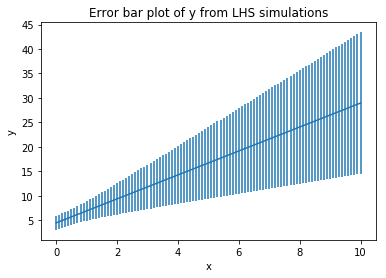

In [143]:
yavg = np.mean(Output, axis=0)
yerr = np.std(Output, axis=0)

plt.errorbar(x,yavg,yerr)
plt.xlabel('x')
# plt.xlabel('time (days)')   # for myodes
plt.ylabel(labelstring)
plt.title('Error bar plot of ' + labelstring + ' from LHS simulations')

plt.show()

### Compute partial rank correlation coefficients to compare simulation outputs with parameters

In [0]:
SampleResult=[]

x_idx = 11          # time or location index of sim results 
x_idx2= x_idx+1     #    to compare w/ param sample vals

LHS=[*zip(*LHSparams)]
LHSarray=np.array(LHS)
Outputarray=np.array(Output)
subOut=Outputarray[0:,x_idx:x_idx2]

LHSout = np.hstack((LHSarray,subOut))
SampleResult = LHSout.tolist()


Ranks=[]
              
for s in range(sampleCount):

    indices = list(range(len(SampleResult[s])))
    indices.sort(key=lambda k: SampleResult[s][k])
    r = [0] * len(indices)
    for i, k in enumerate(indices):
        r[k] = i

    Ranks.append(r)

  
C=np.corrcoef(Ranks);

if np.linalg.det(C) < 1e-16: # determine if singular
    Cinv = np.linalg.pinv(C) # may need to use pseudo inverse
else:
    Cinv = np.linalg.inv(C) 

resultIdx = parameterCount+1
prcc=np.zeros(resultIdx)

for w in range(parameterCount): # compute PRCC btwn each param & sim result
    prcc[w]=-Cinv[w,resultIdx]/np.sqrt(Cinv[w,w]*Cinv[resultIdx,resultIdx])


### Plot the PRCCs for each parameter

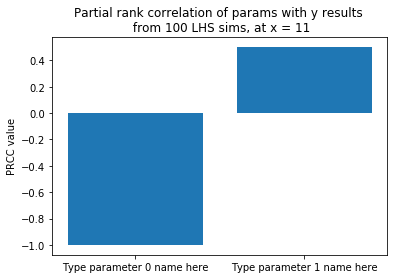

In [145]:
xp=[i for i in range(parameterCount)]

plt.bar(xp,prcc[0:parameterCount], align='center')

bLabels=list(parameters.keys())
plt.xticks(xp, bLabels)

plt.ylabel('PRCC value');

N=str(sampleCount)
loc=str(x_idx)
plt.title('Partial rank correlation of params with ' + labelstring 
          + ' results \n from ' + N + ' LHS sims, at x = ' +loc);

plt.show()

### Can also do PRCCs over time... 

In [0]:
SampleResult=[]

resultIdx = parameterCount+1
prcc=np.zeros((resultIdx,len(x)))

LHS=[*zip(*LHSparams)]
LHSarray=np.array(LHS)
Outputarray=np.array(Output)

for xi in range(len(x)):  # loop through time or location of sim results 
    xi2  = xi+1           # to compare w/ parameter sample vals


    subOut = Outputarray[0:,xi:xi2]

    LHSout = np.hstack((LHSarray,subOut))
    SampleResult = LHSout.tolist()


    Ranks=[]
              
    for s in range(sampleCount):
              
      indices = list(range(len(SampleResult[s])))
      indices.sort(key=lambda k: SampleResult[s][k])
      r = [0] * len(indices)
      for i, k in enumerate(indices):
          r[k] = i
      
      Ranks.append(r)

  
    C=np.corrcoef(Ranks);

    if np.linalg.det(C) < 1e-16: # determine if singular
        Cinv = np.linalg.pinv(C)   # may need to use pseudo inverse
    else:
        Cinv = np.linalg.inv(C) 

    for w in range(parameterCount):  # compute PRCC btwn each param & sim result
        prcc[w,xi]=-Cinv[w,resultIdx]/np.sqrt(Cinv[w,w]*Cinv[resultIdx,resultIdx]) 

### Plot PRCC values as they vary over time or space.
#### *Notice PRCC can change with respect to the independent variable (x-axis). This may be helpful for certain applications, as opposed to only looking at a "snapshot."*

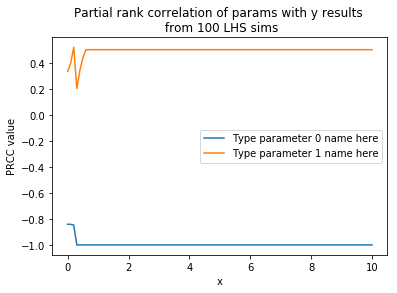

In [147]:
for p in range(parameterCount):
    plt.plot(x,prcc[p,])


labels=list(parameters.keys())
plt.legend(labels)

plt.ylabel('PRCC value');
plt.xlabel('x')

N=str(sampleCount)
plt.title('Partial rank correlation of params with ' + labelstring 
          + ' results \n from ' + N + ' LHS sims');

plt.show()

##That's it! You're done! Happy modeling.